## Machine Learning Models

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import psycopg2
#import AWS_config as creds
#from config import db_password -- not needed but pending AWS_config file
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [ ]:
# Import data from AWS databse -- pending AWS_config file

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                  +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [ ]:
conn,cursor=connect()
com="select * from nyc_listings limit 5"

In [ ]:
cursor.execute(com)

In [ ]:
conn.commit()

In [ ]:
cursor.fetchall()

In [ ]:
df = pd.read_sql_query("select * from nyc_listings", con=conn)
df

In [2]:
# Read in the clean csv
listings_df = pd.read_csv("Resources/clean_nyc_listings.csv")
listings_df

,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review
0,77765,Superior @ Box House,417504,The Box House Hotel,Brooklyn,Greenpoint,40.737770,-73.953660,Hotel room,308,2,42,217,51
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.645290,-73.972380,Private room,299,30,9,356,1419
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.703090,-73.899630,Entire home/apt,425,30,13,365,1030
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,Manhattan,Morningside Heights,40.806300,-73.959850,Private room,75,31,135,219,58
4,80493,Cozy room in East Village with AC,434987,Jennifer,Manhattan,East Village,40.723220,-73.986150,Private room,55,2,207,132,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31500,628769808856889664,Two bedroom apartment in Hoboken New Jersey.,14468718,Burak,Manhattan,West Village,40.740227,-74.027504,Entire home/apt,410,3,2,0,40
31501,27577588,Luxury Studio ON Grove Street E0C - B1CA,37412692,Kim,Manhattan,Ellis Island,40.718220,-74.037940,Entire home/apt,135,365,2,365,1087
31502,654151117629853651,Lovely 3- bedroom apartment,117540494,Miriam,Queens,Rosedale,40.647244,-73.720088,Entire home/apt,180,1,5,0,14
31503,553754115911961053,Trendy 3-bedroom apartment near Manhattan,15048320,India,Manhattan,Upper West Side,40.787320,-74.004470,Entire home/apt,240,5,18,152,16


In [3]:
listings_df.dtypes

id                          int64
name                       object
host_id                     int64
host_name                  object
borough                    object
neighborhood               object
latitude                  float64
longitude                 float64
room_type                  object
price                       int64
minimum_nights              int64
number_of_reviews           int64
availability_365            int64
days_since_last_review      int64
dtype: object

<AxesSubplot:title={'center':'Number of Listings in Each NYC Borough'}, xlabel='Borough', ylabel='Listings Count'>

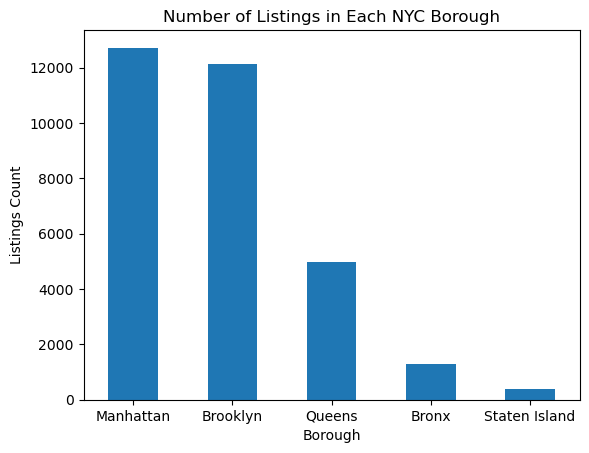

In [4]:
# Create bar plot to visualize frequency of listings in each borough
listings_df['borough'].value_counts().plot(kind='bar', xlabel='Borough', ylabel='Listings Count', 
                                           title='Number of Listings in Each NYC Borough', rot=0)

<AxesSubplot:title={'center':'Number of Listings for Each Room Type'}, xlabel='Room Type', ylabel='Listings Count'>

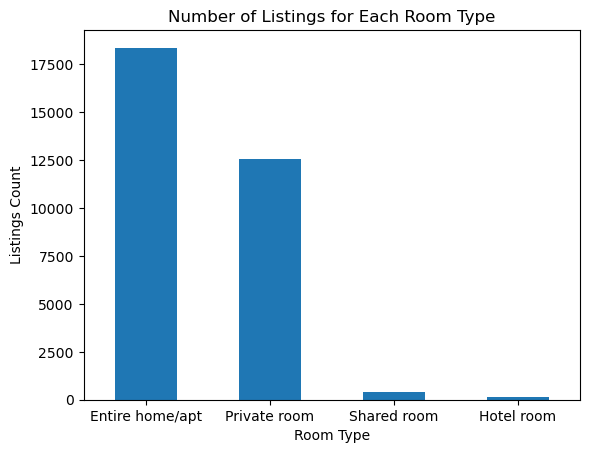

In [5]:
# Create bar plot to visualize frequency of listings for each room type
listings_df["room_type"].value_counts().plot(kind='bar', xlabel="Room Type", ylabel='Listings Count',
                                             title='Number of Listings for Each Room Type', rot=0)

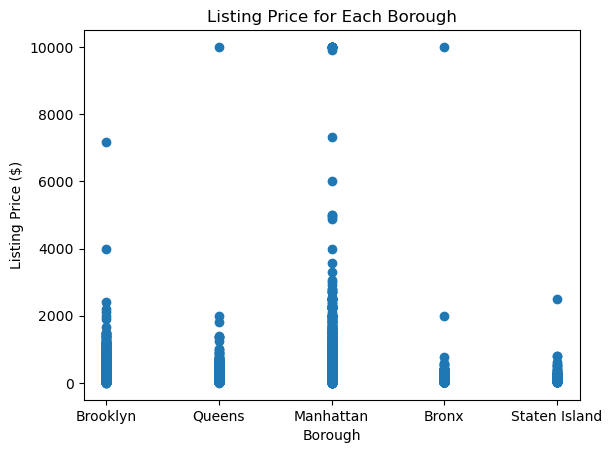

In [6]:
# Visually inspect the relationship between Borough and Price:
plt.scatter(listings_df.borough, listings_df.price)
plt.title("Listing Price for Each Borough")
plt.xlabel("Borough")
plt.ylabel("Listing Price ($)")
plt.show()

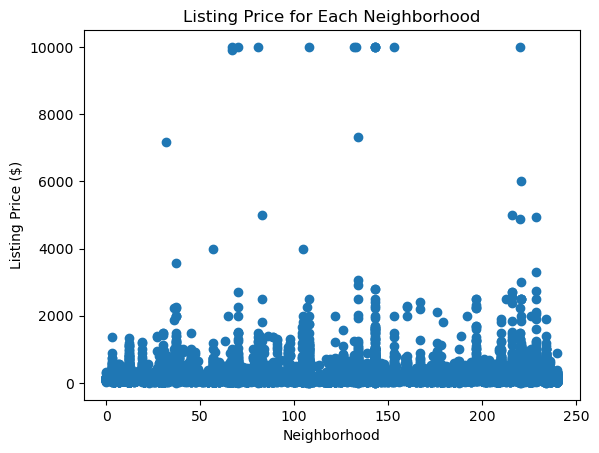

In [77]:
# Visually inspect the relationship between Neighborhood and Price:
plt.scatter(listings_df.neighborhood, listings_df.price)
plt.title("Listing Price for Each Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Listing Price ($)")
plt.show()

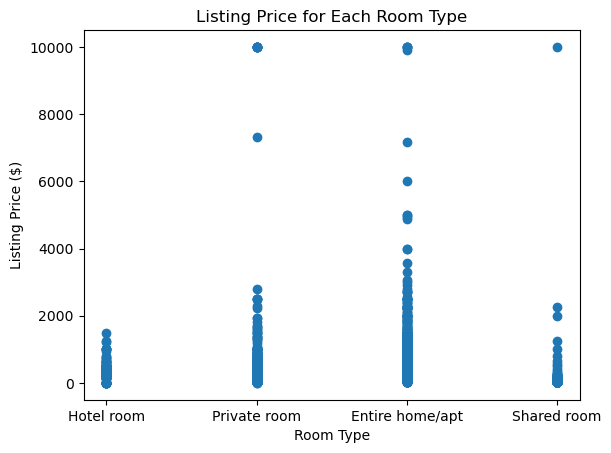

In [8]:
# Visually inspect the relationship between Room Type and Price:
plt.scatter(listings_df.room_type, listings_df.price)
plt.title("Listing Price for Each Room Type")
plt.xlabel("Room Type")
plt.ylabel("Listing Price ($)")
plt.show()

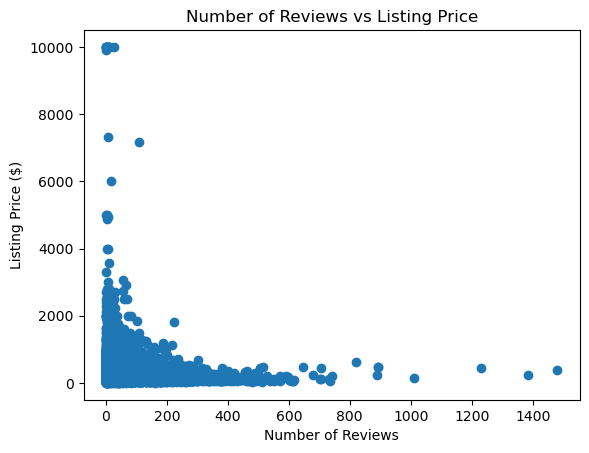

In [9]:
# Visually inspect the relationship between Number of Reviews and Price:
plt.scatter(listings_df.number_of_reviews, listings_df.price)
plt.title("Number of Reviews vs Listing Price")
plt.xlabel("Number of Reviews")
plt.ylabel("Listing Price ($)")
plt.show()

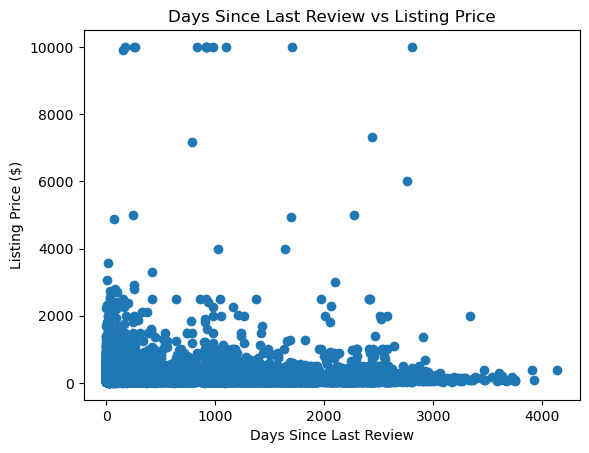

In [10]:
# Visually inspect the relationship between Days Since Last Review and Price:
plt.scatter(listings_df.days_since_last_review, listings_df.price)
plt.title("Days Since Last Review vs Listing Price")
plt.xlabel("Days Since Last Review")
plt.ylabel("Listing Price ($)")
plt.show()

In [11]:
# Create custom encoding for the boroughs
borough_num = {
   "Manhattan": 1,
   "Brooklyn": 2,
   "Queens": 3,
   "Bronx": 4,
   "Staten Island": 5,
}

listings_df["borough_num"] = listings_df["borough"].apply(lambda x: borough_num[x])
listings_df.head()

,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review,borough_num
0,77765,Superior @ Box House,417504,The Box House Hotel,Brooklyn,Greenpoint,40.73777,-73.95366,Hotel room,308,2,42,217,51,2
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64529,-73.97238,Private room,299,30,9,356,1419,2
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70309,-73.89963,Entire home/apt,425,30,13,365,1030,3
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,Manhattan,Morningside Heights,40.80630,-73.95985,Private room,75,31,135,219,58,1
4,80493,Cozy room in East Village with AC,434987,Jennifer,Manhattan,East Village,40.72322,-73.98615,Private room,55,2,207,132,25,1


In [12]:
# Encode neighborhood labels with Scikit-learn
le = LabelEncoder()
listings_df["neighborhood_num"] = le.fit_transform(listings_df["neighborhood"])
listings_df.head()

,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review,borough_num,neighborhood_num
0,77765,Superior @ Box House,417504,The Box House Hotel,Brooklyn,Greenpoint,40.73777,-73.95366,Hotel room,308,2,42,217,51,2,104
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64529,-73.97238,Private room,299,30,9,356,1419,2,122
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70309,-73.89963,Entire home/apt,425,30,13,365,1030,3,185
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,Manhattan,Morningside Heights,40.80630,-73.95985,Private room,75,31,135,219,58,1,146
4,80493,Cozy room in East Village with AC,434987,Jennifer,Manhattan,East Village,40.72322,-73.98615,Private room,55,2,207,132,25,1,70


In [13]:
# Create custom encoding for the room type
room_type_num = {
   "Entire home/apt": 1,
   "Private room": 2,
   "Shared room": 3,
   "Hotel room": 4,
}

listings_df["room_type_num"] = listings_df["room_type"].apply(lambda x: room_type_num[x])
listings_df.head()

,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review,borough_num,neighborhood_num,room_type_num
0,77765,Superior @ Box House,417504,The Box House Hotel,Brooklyn,Greenpoint,40.73777,-73.95366,Hotel room,308,2,42,217,51,2,104,4
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64529,-73.97238,Private room,299,30,9,356,1419,2,122,2
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70309,-73.89963,Entire home/apt,425,30,13,365,1030,3,185,1
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,Manhattan,Morningside Heights,40.80630,-73.95985,Private room,75,31,135,219,58,1,146,2
4,80493,Cozy room in East Village with AC,434987,Jennifer,Manhattan,East Village,40.72322,-73.98615,Private room,55,2,207,132,25,1,70,2


In [14]:
# Drop original columns no longer needed
listings_df = listings_df.drop(["borough", "neighborhood", "room_type"], axis=1)
listings_df.head()

,id,name,host_id,host_name,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review,borough_num,neighborhood_num,room_type_num
0,77765,Superior @ Box House,417504,The Box House Hotel,40.73777,-73.95366,308,2,42,217,51,2,104,4
1,2539,Clean & quiet apt home by the park,2787,John,40.64529,-73.97238,299,30,9,356,1419,2,122,2
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,40.70309,-73.89963,425,30,13,365,1030,3,185,1
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,40.80630,-73.95985,75,31,135,219,58,1,146,2
4,80493,Cozy room in East Village with AC,434987,Jennifer,40.72322,-73.98615,55,2,207,132,25,1,70,2


In [15]:
# Rename columns
listings_df.rename(columns = {"borough_num":"borough", "neighborhood_num":"neighborhood", "room_type_num":"room_type"}, inplace = True)
listings_df.head()

,id,name,host_id,host_name,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,days_since_last_review,borough,neighborhood,room_type
0,77765,Superior @ Box House,417504,The Box House Hotel,40.73777,-73.95366,308,2,42,217,51,2,104,4
1,2539,Clean & quiet apt home by the park,2787,John,40.64529,-73.97238,299,30,9,356,1419,2,122,2
2,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,40.70309,-73.89963,425,30,13,365,1030,3,185,1
3,45936,Couldn't Be Closer To Columbia Uni,867225,Rahul,40.80630,-73.95985,75,31,135,219,58,1,146,2
4,80493,Cozy room in East Village with AC,434987,Jennifer,40.72322,-73.98615,55,2,207,132,25,1,70,2


### Linear Regression Between Room Type and Price

In [16]:
# Format the data to meet the requirements of the Scikit-learn library:
X = listings_df.room_type.values.reshape(-1, 1)

In [17]:
# Examine the first five entries in X
X[:5]

array([[4],
       [2],
       [1],
       [2],
       [2]], dtype=int64)

In [18]:
# Examine the shape of X
X.shape

(31505, 1)

In [19]:
# Assign the target variable, or the Price column, to y
y = listings_df.price
y

0        308
1        299
2        425
3         75
4         55
        ... 
31500    410
31501    135
31502    180
31503    240
31504     40
Name: price, Length: 31505, dtype: int64

In [20]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=1)
X_train.shape

(23628, 1)

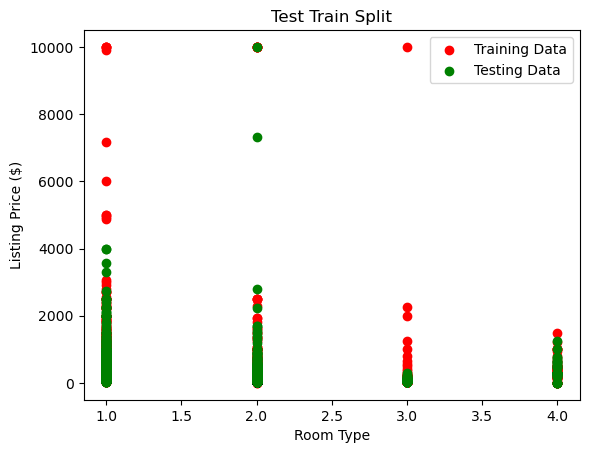

In [21]:
# Visualize the test train split
plt.scatter(X_train, Y_train, label='Training Data', color='r')
plt.scatter(X_test, Y_test, label='Testing Data', color='g')
plt.legend()
plt.title("Test Train Split")
plt.xlabel("Room Type")
plt.ylabel("Listing Price ($)")
plt.show()

In [22]:
# Create an instance of a specific object called model that will analyze the data and store information specific to this dataset
model = LinearRegression()

In [23]:
# After a model is instantiated, it will analyze the data and attempt to learn patterns in the data (train the model)
model.fit(X, y)

LinearRegression()

In [24]:
# After the learning stage, the predict() method is used to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)

(7877,)


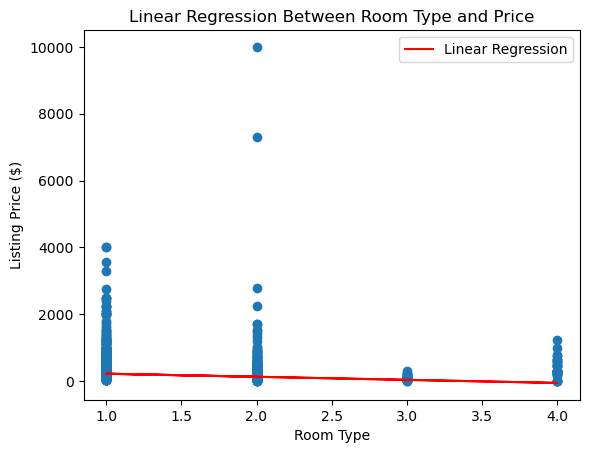

In [25]:
# Plot the predictions as a red line against the data points
plt.scatter(X_test, Y_test)
plt.title("Linear Regression Between Room Type and Price")
plt.xlabel("Room Type")
plt.ylabel("Listing Price ($)")
plt.plot(X_test, y_pred, label='Linear Regression', color='red')
plt.legend()
plt.show()

In [26]:
# Run a prediction on the model (ie. Price for Room Type 3 "Shared room")
model.predict(np.array([[3]]))[0]

39.664605199204175

In [27]:
# Examine the specific parameters of the model (the slope and the y-intercept)
print(model.coef_)
print(model.intercept_)

[-91.93008369]
315.4548562591679


In [28]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(Y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  58804.62157037436
RMSE:  29402.31078518718


### Linear Regression Between Borough and Price

In [29]:
# Format the data, examine the first five entries in X, and examine the shape of X
X = listings_df.borough.values.reshape(-1, 1)
X[:5]
X.shape

(31505, 1)

In [30]:
# Assign the target variable, or the Price column, to y
y = listings_df.price
y

0        308
1        299
2        425
3         75
4         55
        ... 
31500    410
31501    135
31502    180
31503    240
31504     40
Name: price, Length: 31505, dtype: int64

In [31]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=1)
X_train.shape

(23628, 1)

In [32]:
# Create the linear model and train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

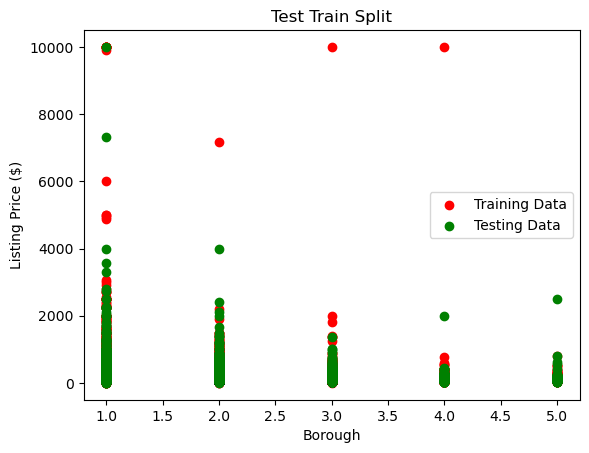

In [33]:
# Visualize the test train split
plt.scatter(X_train, Y_train, label='Training Data', color='r')
plt.scatter(X_test, Y_test, label='Testing Data', color='g')
plt.legend()
plt.title("Test Train Split")
plt.xlabel("Borough")
plt.ylabel("Listing Price ($)")
plt.show()

In [34]:
# Use the model to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)

(7877,)


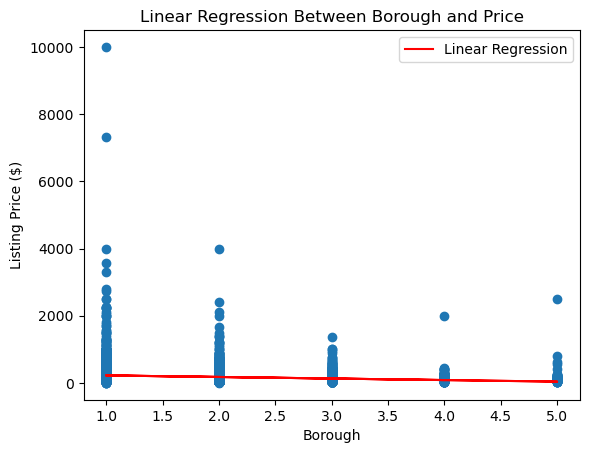

In [35]:
# Plot the predictions as a red line against the data point
plt.scatter(X_test, Y_test)
plt.title("Linear Regression Between Borough and Price")
plt.xlabel("Borough")
plt.ylabel("Listing Price ($)")
plt.plot(X_test, y_pred, label='Linear Regression', color='red')
plt.legend()
plt.show()

In [36]:
# Run a prediction on the model (ie. Price for Borough 3 "Queens")
model.predict(np.array([[3]]))[0]

131.06177361608883

In [37]:
# Examine the specific parameters of the model (the slope and the y-intercept)
print(model.coef_)
print(model.intercept_)

[-46.14008509]
269.48202887158897


In [38]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(Y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  59998.53032285654
RMSE:  29999.26516142827


### Linear Regression Between Neighborhood and Price

In [39]:
# Format the data, examine the first five entries in X, and examine the shape of X
X = listings_df.neighborhood.values.reshape(-1, 1)
X[:5]
X.shape

(31505, 1)

In [40]:
# Assign the target variable, or the Price column, to y
y = listings_df.price
y

0        308
1        299
2        425
3         75
4         55
        ... 
31500    410
31501    135
31502    180
31503    240
31504     40
Name: price, Length: 31505, dtype: int64

In [41]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=1)
X_train.shape

(23628, 1)

In [42]:
# Create the linear model and train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

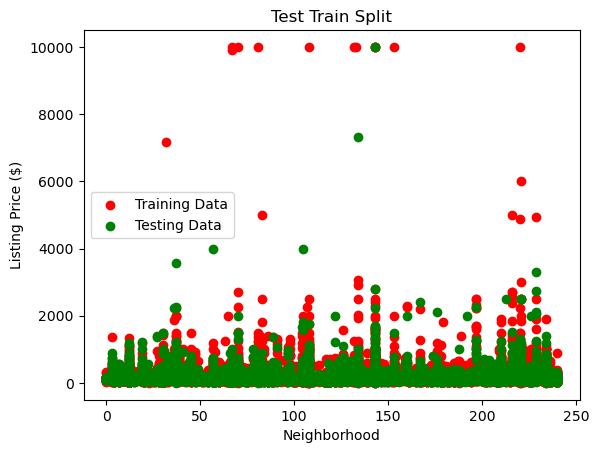

In [43]:
# Visualize the test train split
plt.scatter(X_train, Y_train, label='Training Data', color='r')
plt.scatter(X_test, Y_test, label='Testing Data', color='g')
plt.legend()
plt.title("Test Train Split")
plt.xlabel("Neighborhood")
plt.ylabel("Listing Price ($)")
plt.show()

In [44]:
# Use the model to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)

(7877,)


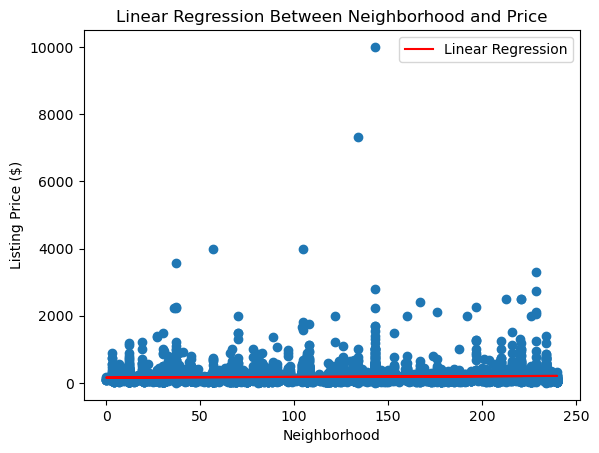

In [45]:
# Plot the predictions as a red line against the data point
plt.scatter(X_test, Y_test)
plt.title("Linear Regression Between Neighborhood and Price")
plt.xlabel("Neighborhood")
plt.ylabel("Listing Price ($)")
plt.plot(X_test, y_pred, label='Linear Regression', color='red')
plt.legend()
plt.show()

In [46]:
# Run a prediction on the model (ie. Price for Neighborhood 104 "Greenpoint")
model.predict(np.array([[104]]))[0]

180.11669047362074

In [47]:
# Examine the specific parameters of the model (the slope and the y-intercept)
print(model.coef_)
print(model.intercept_)

[0.20889991]
158.39109979249355


In [48]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(Y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  61291.1957878268
RMSE:  30645.5978939134


### Linear Regression Between Number of Reviews and Price

In [49]:
# Format the data, examine the first five entries in X, and examine the shape of X
X = listings_df.number_of_reviews.values.reshape(-1, 1)
X[:5]
X.shape

(31505, 1)

In [50]:
# Assign the target variable, or the Price column, to y
y = listings_df.price
y

0        308
1        299
2        425
3         75
4         55
        ... 
31500    410
31501    135
31502    180
31503    240
31504     40
Name: price, Length: 31505, dtype: int64

In [51]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=1)
X_train.shape

(23628, 1)

In [52]:
# Create the linear model and train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

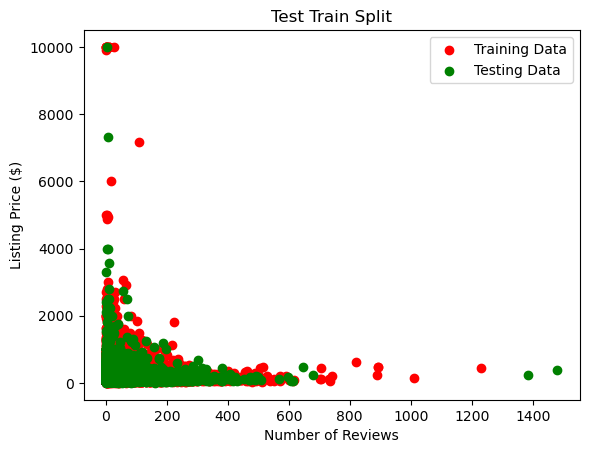

In [53]:
# Visualize the test train split
plt.scatter(X_train, Y_train, label='Training Data', color='r')
plt.scatter(X_test, Y_test, label='Testing Data', color='g')
plt.legend()
plt.title("Test Train Split")
plt.xlabel("Number of Reviews")
plt.ylabel("Listing Price ($)")
plt.show()

In [54]:
# Use the model to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)

(7877,)


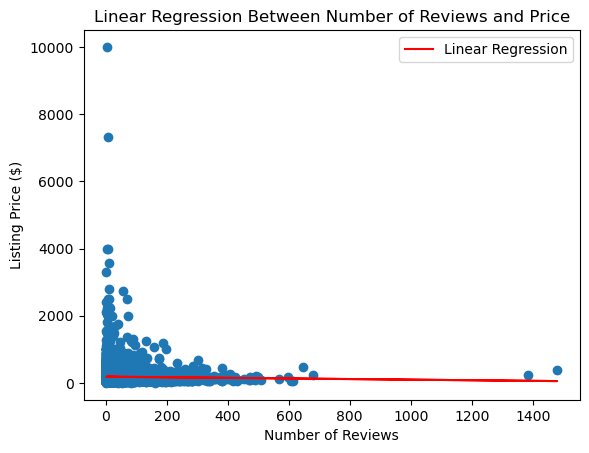

In [55]:
# Plot the predictions as a red line against the data point
plt.scatter(X_test, Y_test)
plt.title("Linear Regression Between Number of Reviews and Price")
plt.xlabel("Number of Reviews")
plt.ylabel("Listing Price ($)")
plt.plot(X_test, y_pred, label='Linear Regression', color='red')
plt.legend()
plt.show()

In [56]:
# Run a prediction on the model (ie. Price for a listing with 200 Reviews )
model.predict(np.array([[200]]))[0]

168.33246345930024

In [57]:
# Examine the specific parameters of the model (the slope and the y-intercept)
print(model.coef_)
print(model.intercept_)

[-0.08873725]
186.07991395745594


In [58]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(Y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  61499.53927450242
RMSE:  30749.76963725121


### Linear Regression Between Days Since Last Review and Price

In [59]:
# Format the data, examine the first five entries in X, and examine the shape of X
X = listings_df.days_since_last_review.values.reshape(-1, 1)
X[:5]
X.shape

(31505, 1)

In [60]:
# Assign the target variable, or the Price column, to y
y = listings_df.price
y

0        308
1        299
2        425
3         75
4         55
        ... 
31500    410
31501    135
31502    180
31503    240
31504     40
Name: price, Length: 31505, dtype: int64

In [61]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=1)
X_train.shape

(23628, 1)

In [62]:
# Create the linear model and train the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

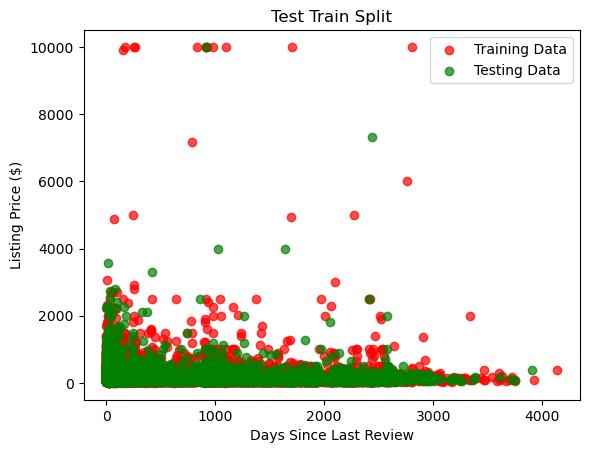

In [63]:
# Visualize the test train split
plt.scatter(X_train, Y_train, label='Training Data', color='r', alpha=.7)
plt.scatter(X_test, Y_test, label='Testing Data', color='g', alpha=.7)
plt.legend()
plt.title("Test Train Split")
plt.xlabel("Days Since Last Review")
plt.ylabel("Listing Price ($)")
plt.show()

In [64]:
# Use the model to generate predictions
y_pred = model.predict(X_test)
print(y_pred.shape)

(7877,)


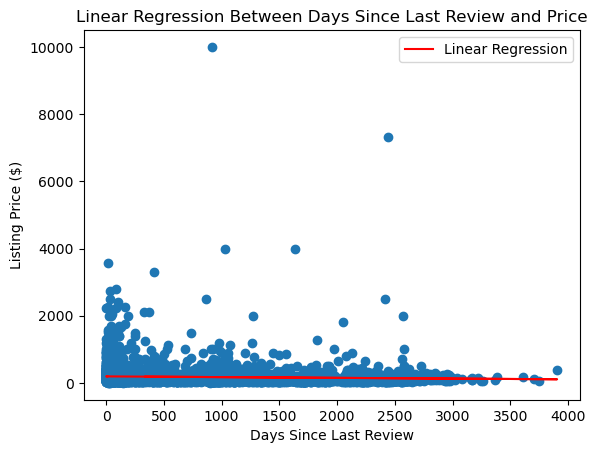

In [65]:
# Plot the predictions as a red line against the data points
plt.scatter(X_test, Y_test)
plt.title("Linear Regression Between Days Since Last Review and Price")
plt.xlabel("Days Since Last Review")
plt.ylabel("Listing Price ($)")
plt.plot(X_test, y_pred, label='Linear Regression', color='red')
plt.legend()
plt.show()

In [66]:
# Run a prediction on the model (ie. Price for a listing with 100 days since its last review)
model.predict(np.array([[100]]))[0]

192.57773270116888

In [67]:
# Examine the specific parameters of the model (the slope and the y-intercept)
print(model.coef_)
print(model.intercept_)

[-0.02199426]
194.77715850896996


In [68]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(Y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  61132.2410901104
RMSE:  30566.1205450552


### Random Forest Regression between Price and Borough, Neighborhood, Room Type, Number of Reviews, and Days Since Last Review

In [69]:
# Format the data and assign variables
X = listings_df.borough.values.reshape(-1,1)
y = listings_df.price.values.reshape(-1,1) 

In [70]:
X = listings_df[["borough", "neighborhood", "room_type", "number_of_reviews", "days_since_last_review"]]

In [71]:
# Split into training and testing sets
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [72]:
# Create the linear model and train the model
RandomForestRegModel = RandomForestRegressor()
RandomForestRegModel.fit(X_train, Y_train)

C:\Users\lkcac\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor()

In [73]:
# Use the model to generate predictions
y_pred = RandomForestRegModel.predict(X_test)
y_pred

array([567.14,  95.93, 286.27, ...,  64.69, 281.13, 144.69])

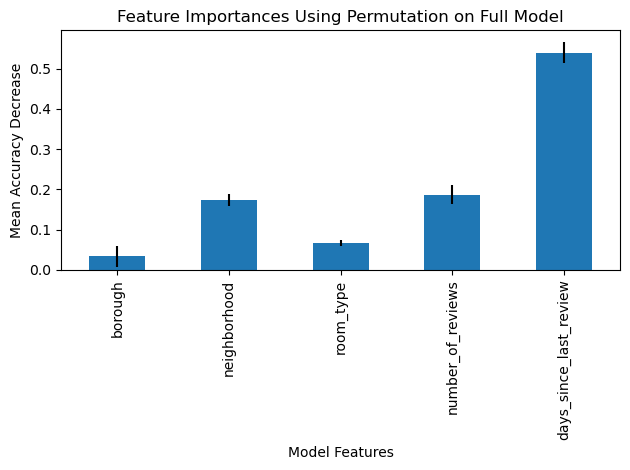

In [76]:
# Determine the Feature (Input variable) importance based on feature permutation
importances = RandomForestRegModel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RandomForestRegModel.estimators_], axis=0)
forest_importances = pd.Series(importances, 
                               index=["borough", "neighborhood", "room_type", "number_of_reviews", "days_since_last_review"])
result = permutation_importance(RandomForestRegModel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# Plot the importance ranking
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full Model")
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xlabel("Model Features")
fig.tight_layout()
plt.show()

In [75]:
# Print the Mean Squared Error (MSE) and Root Mean Square Error (RMSE) scores
mse = mean_squared_error(y_test, y_pred)
print("MSE: ",mse)
print("RMSE: ", mse*(1/2.0))

MSE:  93684.25342209406
RMSE:  46842.12671104703
